# Task 3
---
Binary classification

[Kaggle](https://www.kaggle.com/dipayanbiswas/parkinsons-disease-speech-signal-features)

# Dataset description

__Context__

This dataset is collected from UCI Machine Learning Repository through the following link: [click](https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification#)

__Data Set Information:__

The data used in this study were gathered from 188 patients with PD (107 men and 81 women) with ages ranging from 33 to 87 (65.1±10.9) at the Department of Neurology in Cerrahpaya Faculty of Medicine, Istanbul University. The control group consists of 64 healthy individuals (23 men and 41 women) with ages varying between 41 and 82 (61.1±8.9). During the data collection process, the microphone is set to 44.1 KHz and following the physician's examination, the sustained phonation of the vowel /a/ was collected from each subject with three repetitions.

__Attribute Information:__

Various speech signal processing algorithms including Time Frequency Features, Mel Frequency Cepstral Coefficients (MFCCs), Wavelet Transform based Features, Vocal Fold Features and TWQT features have been applied to the speech recordings of Parkinson's Disease (PD) patients to extract clinically useful information for PD assessment.

Attribute description:

- Baseline Features: Col3 to Col23
- Intensity Parameters: Col24 to Col26
- Formant Frequencies: Col27 to Col30
- Bandwidth Parameters: Col31 to Col34
- Vocal Fold: Col35 to Col56
- MFCC: Col57 to Col140
- Wavelet Features: Col141 to Col322
- TQWT Features: Col323 to Col754
- Class: Col755

[Similar paper](https://arxiv.org/ftp/arxiv/papers/1905/1905.00377.pdf)

# Import required libraries

In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils import resample

from umap import UMAP

from sklearn_pandas import DataFrameMapper, gen_features

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from pprint import pprint

from imblearn.over_sampling import SMOTENC

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme()

In [2]:
PALETTE = sns.color_palette("Set2")
RANDOM_STATE = 42

In [3]:
sns.set_context("paper", rc={"font.size":12, 
                             "figure.titlesize":18, 
                             "axes.titlesize":15, 
                             "axes.labelsize":13, 
                             "xtick.labelsize": 13,
                             "ytick.labelsize": 13,
                             "legend.fontsize": 9,
                             "legend.title_fontsize": 11}) 

# EDA

In [4]:
data = pd.read_csv('archive/pd_speech_features.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


There are 756 rows with a lot of columns - 755. Each person from 

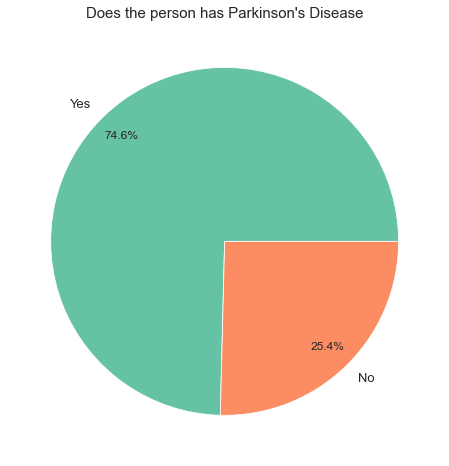

In [6]:
sizes = dict(data['class'].value_counts())

plt.figure(figsize=(12, 8))
plt.title("Does the person has Parkinson's Disease")
plt.pie(sizes.values(), labels=['Yes', 'No'], autopct="%.1f%%", pctdistance=0.85, colors=PALETTE)

plt.show()

Target feature is unbalanced, like in most medical data, but this time we have 0 class underrepresented (no Parkinsons's Disease)

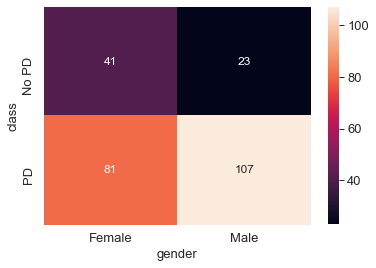

In [7]:
sns.heatmap(pd.crosstab(data['class'], data['gender']).divide(3).astype('int64'), 
            yticklabels=['No PD', 'PD'],
            xticklabels=['Female', 'Male'],
            annot=True,
            fmt='d')

plt.show()

We have:
- 41 Females and 23 Males without PD
- 81 Females and 107 Males with PD

Males are underrepresented in healthy group

Females are underrepresented in PD group

In [8]:
X = data.drop(columns='class')
y = data['class']

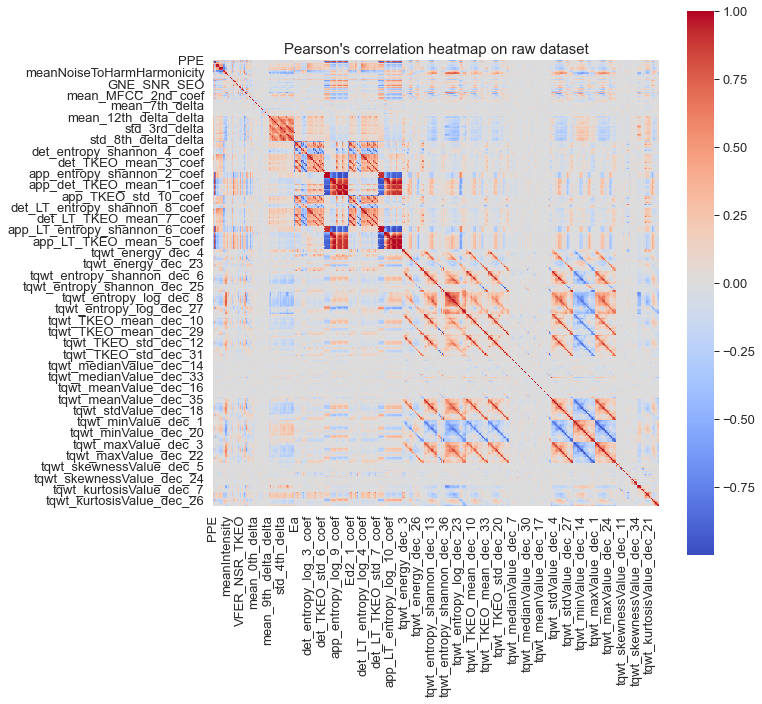

In [9]:
corr_matr = X.drop(columns=['id', 'gender']).corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr_matr, cmap='coolwarm', square=True)
plt.title("Pearson's correlation heatmap on raw dataset")
plt.show()

We know that there are correlated features in this dataset, so non-robust to multicollinearity models might suffer

# Feature scaling

If we look on feature distributions, we will see somewhere near to normal skewed distributions and hardly skewed distributions

These are the first 20 features, but i checked features in each attribute type (see attribute descriptin) and the distributions are pretty similar

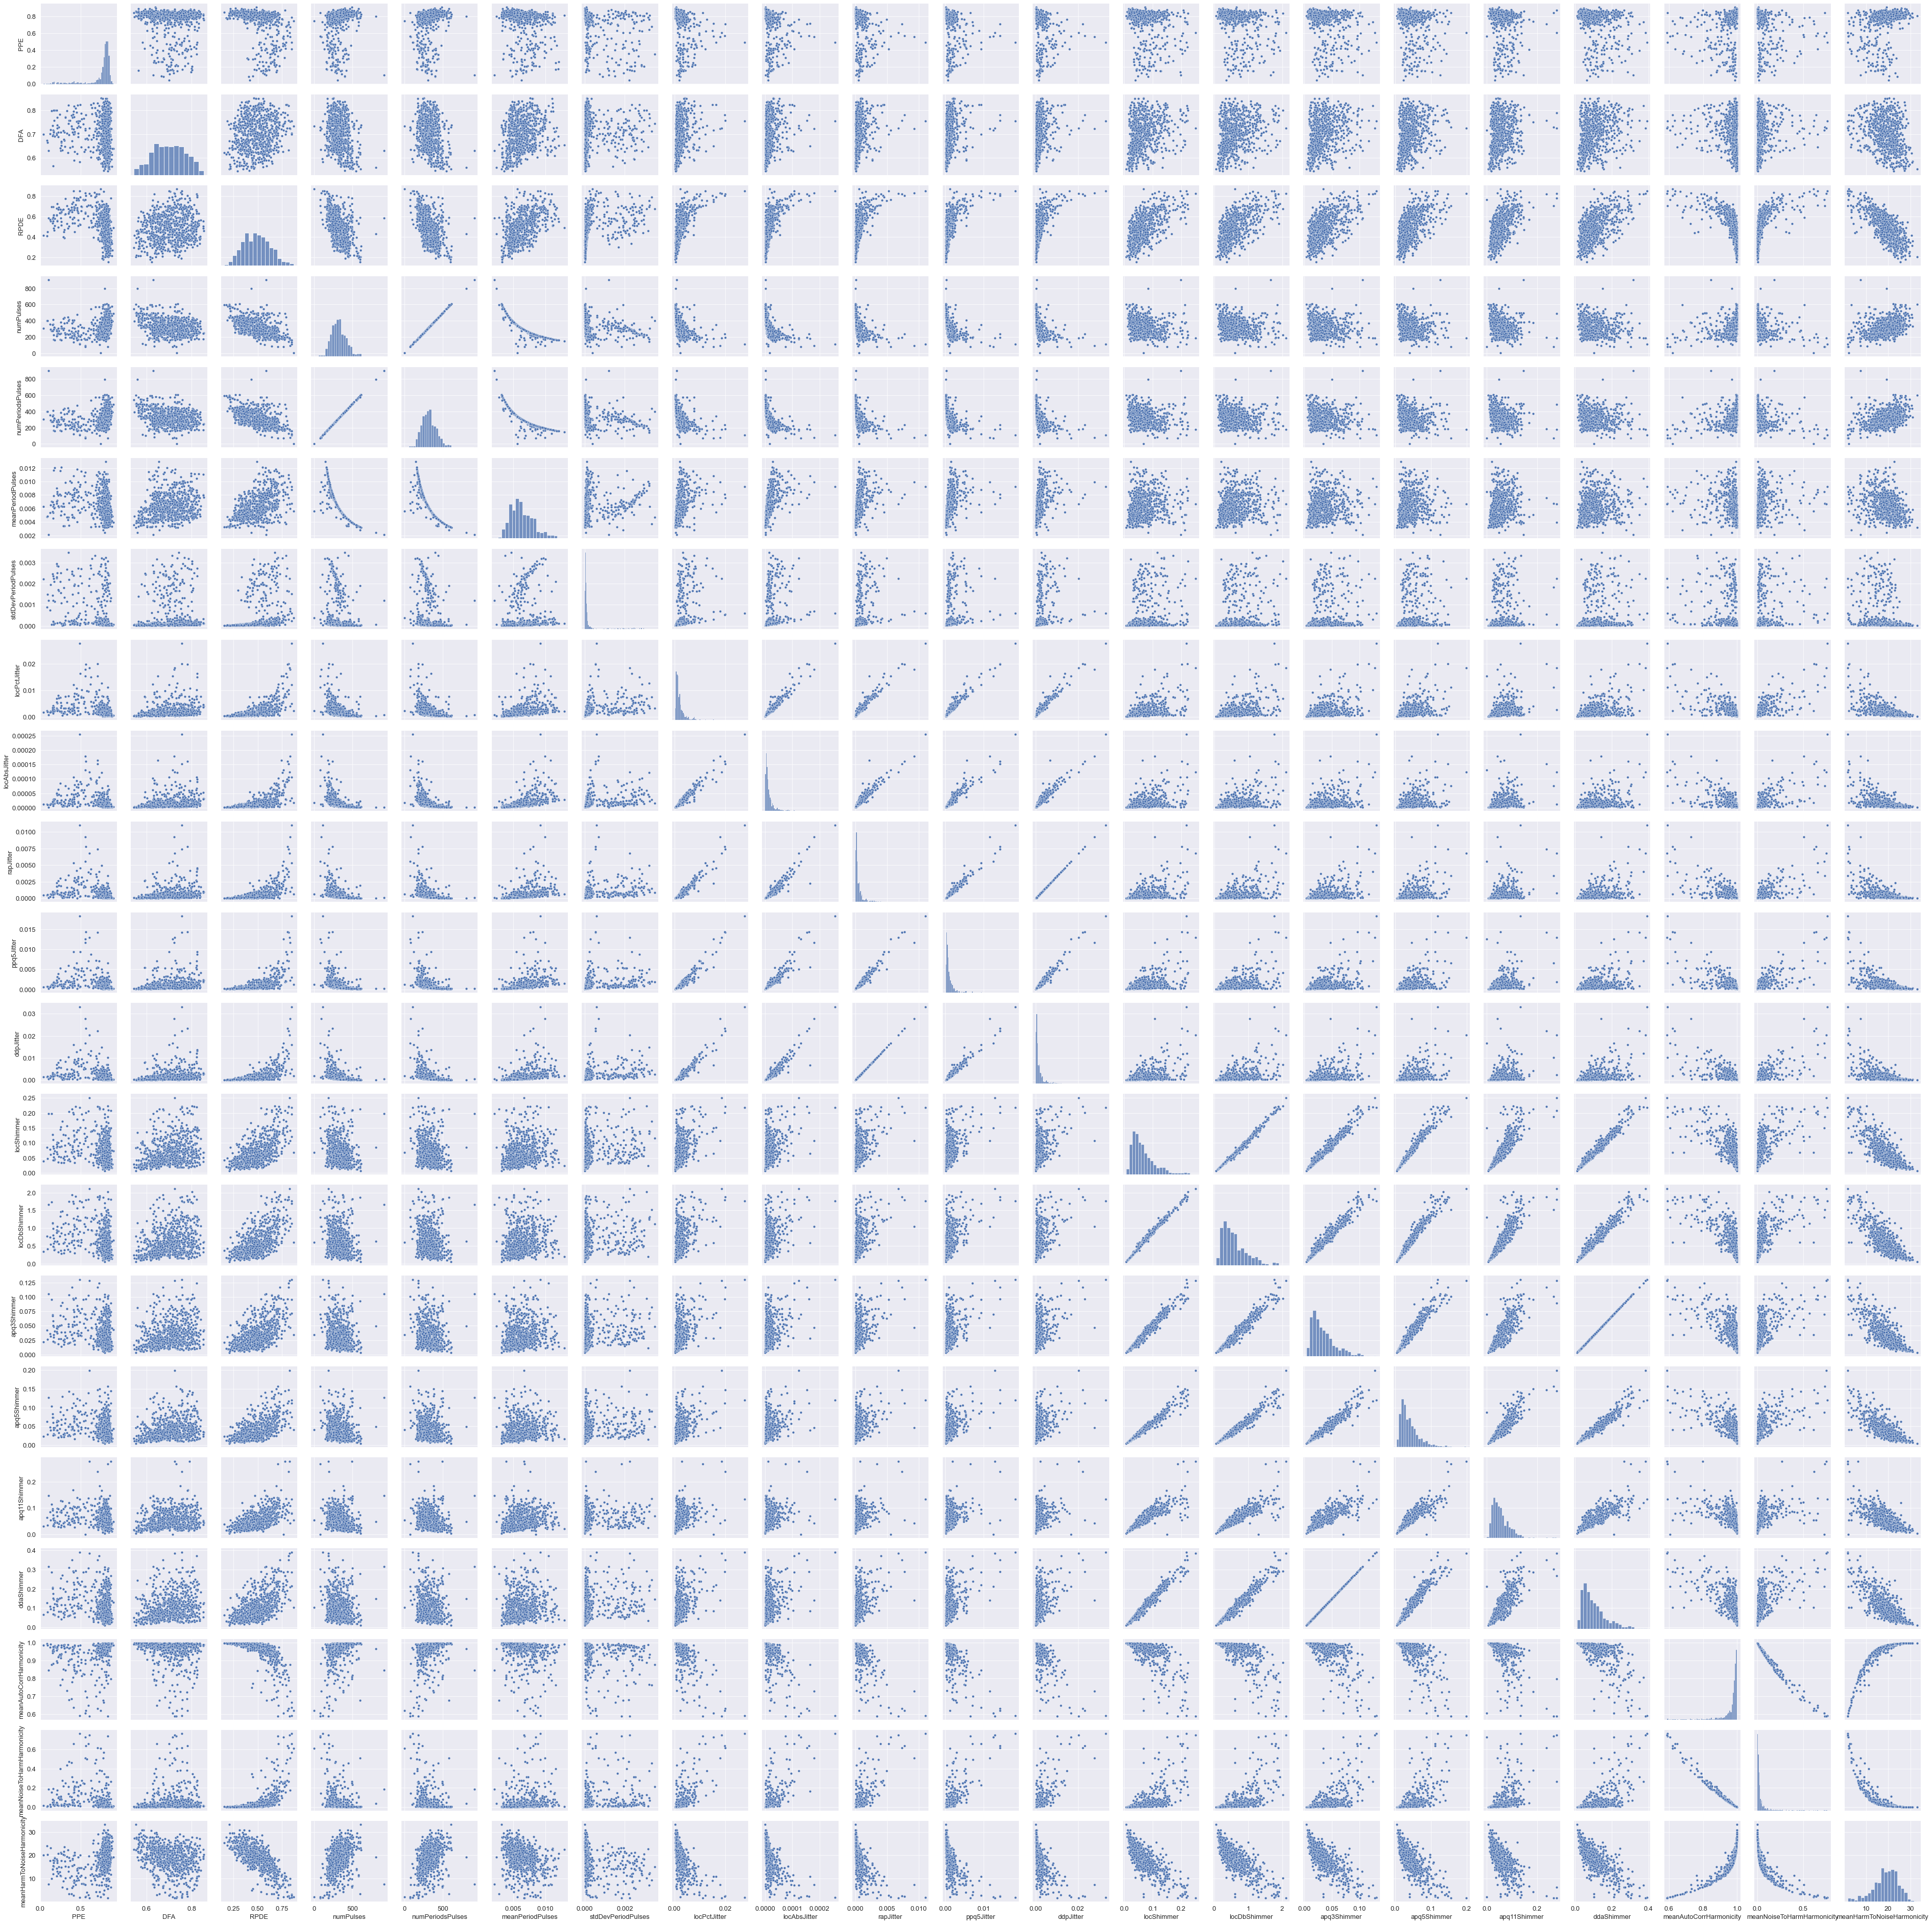

In [121]:
g = sns.pairplot(data=X.iloc[:, 2:23], 
                 kind='scatter')

plt.tight_layout()

I will use QuantileTransformer for feature scaling. This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of outliers

In [110]:
scaler = gen_features(
    columns = [[c] for c in X.iloc[:, 2:].columns.values],
    classes=[{'class': QuantileTransformer, 'output_distribution': 'normal'}]
)

In [11]:
scaling_mapper = DataFrameMapper(scaler, default=None, df_out=True)
X_scaled = scaling_mapper.fit_transform(X)

In [12]:
X_scaled

PPE       DFA      RPDE  numPulses  numPeriodsPulses  \
0    1.399746  0.219205  0.580482  -0.843989         -0.843989   
1   -0.652766 -0.061459  0.368390  -0.948163         -0.948163   
2    1.324219 -0.277421  0.694423  -0.990655         -0.985246   
3   -1.408644  1.270312  0.728635  -1.723666         -1.709182   
4   -1.580872  1.292955  0.291249  -0.922455         -0.919917   
..        ...       ...       ...        ...               ...   
751 -0.008300 -2.147065 -1.558118   0.971849          0.971849   
752 -2.181600 -2.056492  0.715707   0.940385          0.927547   
753  2.477112  0.270527 -0.094763   0.648663          0.648663   
754  0.795212  0.588359  0.098098   0.287787          0.287787   
755  0.098098  0.836900 -0.124825   0.287787          0.287787   

     meanPeriodPulses  stdDevPeriodPulses  locPctJitter  locAbsJitter  \
0            0.924998            0.138220      0.479212      0.626288   
1            1.060886           -0.088095      0.301657      0.537781   
2            1.108723           -0.329574      0.192077      0.455143   
3            2.004345            0.694423      1.206008      1.464540   
4            1.009817            1.957139      1.436032      1.408644   
..                ...                 ...           ...           ...   
751         -0.955999           -0.590334     -1.464540     -1.382275   
752         -0.998822            0.763722     -0.083096     -0.407768   
753         -0.632359            0.294715     -1.105659     -1.035014   
754         -0.263646           -0.497916     -0.761501     -0.685997   
755         -0.270527           -1.102605     -1.023735     -0.875215   

     rapJitter  ...  tqwt_kurtosisValue_dec_29  tqwt_kurtosisValue_dec_30  \
0     0.715707  ...                  -1.139956                  -0.455143   
1     0.449626  ...                  -0.620241                   0.711425   
2     0.530123  ...                  -1.365215                   0.284328   
3     1.352677  ...                  -0.632359                  -0.111452   
4     1.431392  ...                  -0.114793                   0.001660   
..         ...  ...                        ...                        ...   
751  -1.499381  ...                  -0.924998                  -0.865517   
752  -0.592311  ...                  -1.957139                  -2.477112   
753  -1.099562  ...                   0.880095                   0.763722   
754  -0.535863  ...                   0.368390                   0.253347   
755  -0.768174  ...                   0.580482                   0.267085   

     tqwt_kurtosisValue_dec_31  tqwt_kurtosisValue_dec_32  \
0                    -0.151641                   0.181941   
1                     0.698654                   0.685997   
2                     0.557064                   0.681802   
3                     0.694423                  -0.024903   
4                     0.215806                   0.514901   
..                         ...                        ...   
751                  -1.616620                  -0.209014   
752                  -1.604476                   0.222607   
753                   0.277421                  -0.772641   
754                  -2.114916                  -2.259681   
755                   0.014941                  -0.549326   

     tqwt_kurtosisValue_dec_33  tqwt_kurtosisValue_dec_34  \
0                    -0.078100                  -1.667756   
1                     0.526306                  -0.024903   
2                     0.021582                  -1.248302   
3                    -0.011620                  -0.322571   
4                     0.652766                   0.134869   
..                         ...                        ...   
751                  -0.386215                  -0.899828   
752                  -0.124825                  -0.054808   
753                  -1.399746                  -0.732971   
754                  -2.354592                  -1.580872   
755        

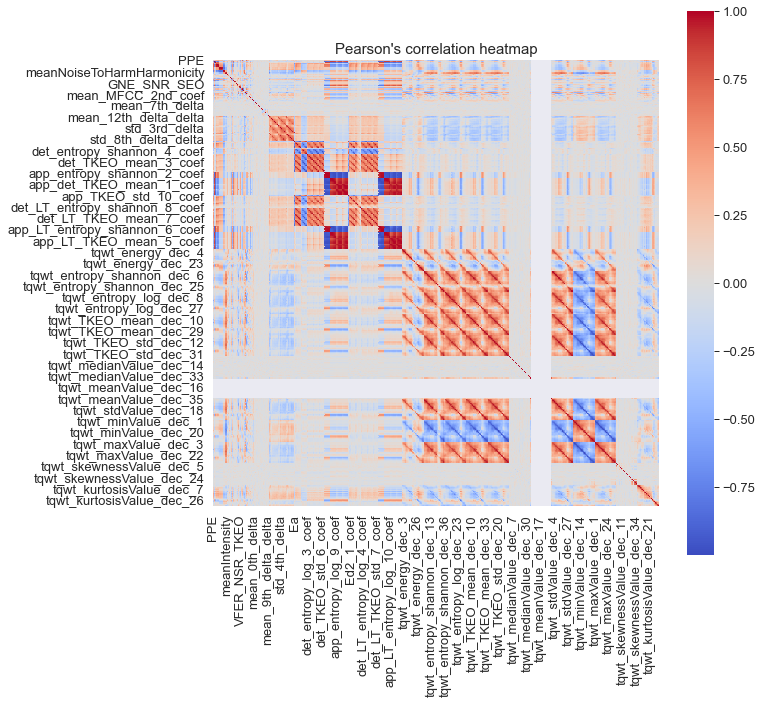

In [13]:
corr_matr = X_scaled.drop(columns=['id', 'gender']).corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr_matr, cmap='coolwarm', square=True)
plt.title("Pearson's correlation heatmap")
plt.show()

And the correlations after scaling have become bigger, I'll use PCA after to fix this

# Cross-validation 

Cross-validation in our data set requires stratifying by class label and also grouping by `id` 

In [143]:
def get_mean_cv_scores_df(estimator, X: pd.DataFrame, y: pd.Series, print_fold_scores=False, plot_cm=False, upsampling=False, resampling=False):
    """Calculates estimators's cross-validation scores on (X, y) dataset 
    
    Parameters
    ----------
    estimator : estimator to evaluate
    X : Data set to cross-validate on
    y : Data set target labels
    print_fold_scores : Set to True to print scores for each fold in cv
    plot_cm : Set to True to plot cofusion matrix
    upsampling : Set to True to upsample train data in each fold
    resampling : Set to True to resample train data in each fold
    """
    cv_scores = {'Accuracy': [],
                 'Recall': [],
                 'Precision': [],
                 'ROC-AUC': []}
    
    estimator_name = type(estimator).__name__
    
    # Stratify by target and group by id in order to prevent getting records 
    # of one person in train and test set
    fold = StratifiedGroupKFold(5, shuffle=True, random_state=RANDOM_STATE)
    
    for train_index, test_index in fold.split(X, y, groups=X['id']):
        X_train, X_test = X.iloc[train_index].drop(columns='id'), X.iloc[test_index].drop(columns='id')
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if resampling:
            X_train, y_train = resample_(X_train, y_train)
        if upsampling:
            X_train, y_train = upsample(X_train, y_train)
        
        estimator.fit(X_train, y_train)
        predictions = estimator.predict(X_test)
        probabilities = estimator.predict_proba(X_test)
        
        cv_scores['Accuracy'].append(accuracy_score(y_test, predictions))
        cv_scores['Recall'].append(recall_score(y_test, predictions, pos_label=1))
        cv_scores['Precision'].append(precision_score(y_test, predictions, pos_label=1))
        cv_scores['ROC-AUC'].append(roc_auc_score(y_test, probabilities[:, 1]))
    
    if print_fold_scores:
        pprint(cv_scores)
    
    mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
    mean_cv_scores_df = pd.DataFrame.from_dict(data={estimator_name: mean_cv_scores.values()}, 
                                               orient='index', 
                                               columns=mean_cv_scores.keys())
    
    if plot_cm:
        plot_confusion_matrix(y_test, predictions, estimator_name)
        
    return mean_cv_scores_df

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, estimator_name: str):
    """Plots confusion matrix for the last fold
    
    Parameters
    ----------
    y_true : True class labels
    y_pred : Predicted class labels
    """
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf,         
                yticklabels=['No PD', 'PD'],
                xticklabels=['No PD', 'PD'],
                annot=True,
                fmt='d')
    plt.title(f'{estimator_name} confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def upsample(X: pd.DataFrame, y: pd.Series):
    """Upsamples dataset with SOMTENC 
    
    Parameters
    ----------
    X : Data set to uspsample
    y : Data set class labels
    
    Returns:
    X_upsampled : upsampled dataset
    y_upsampled : upsampled dataset class labels
    """
    
    # categorical features indicies for SMOTENC
    cat_features_indicies = X.columns.get_loc("gender")
    
    smotenc = SMOTENC([cat_features_indicies], random_state=RANDOM_STATE, sampling_strategy=1)
    X_upsampled, y_upsampled = smotenc.fit_resample(X, y)
    
    return X_upsampled, y_upsampled
    
def resample_(X: pd.DataFrame, y: pd.Series):
    """Resamples class proportions in each gender
    
    Parameters
    ----------
    X : Data set to resample
    y : Data set class to resample
    
    Returns:
    X_upsampled : upsampled dataset
    y_upsampled : upsampled dataset class labels
    """
    
    X_full = X.copy()
    X_full['class_'] = y

    # resampling gender proportions in 1 class
    df_majority_1 = X_full.query('class_ == 1 and gender == 1')
    df_minority_1 = X_full.query('class_ == 1 and gender == 0')

    df_minority_resampled_1 = resample(df_minority_1, 
                                       replace=True,
                                       n_samples=len(df_majority_1),
                                       random_state=RANDOM_STATE)

    df_resampled_1 = pd.concat([df_majority_1, df_minority_resampled_1])

    # resampling gender proportions in 0 class
    df_majority_0 = X_full.query('class_ == 0 and gender == 0')
    df_minority_0 = X_full.query('class_ == 0 and gender == 1')

    df_minority_resampled_0 = resample(df_minority_0, 
                                       replace=True,
                                       n_samples=len(df_majority_0),
                                       random_state=RANDOM_STATE)

    df_resampled_0 = pd.concat([df_majority_0, df_minority_resampled_0])

    # Combining two resampled subsets
    df_resampled = pd.concat([df_resampled_1, df_resampled_0])

    X_resampled = df_resampled.drop(columns='class_')
    y_resampled = df_resampled['class_']
    
    return X_resampled, y_resampled

That's how resampling method works:

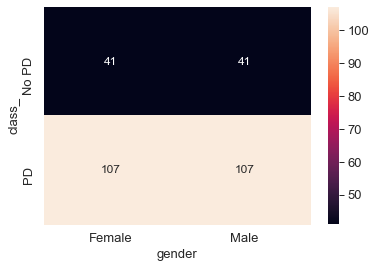

In [144]:
X_resampled, y_resampled = resample_(X_scaled, y)

sns.heatmap(pd.crosstab(y_resampled, X_resampled['gender']).divide(3).astype('int64'), 
            yticklabels=['No PD', 'PD'],
            xticklabels=['Female', 'Male'],
            annot=True,
            fmt='d')

plt.show()

Now let's check the scores from diferent model out-of-box

## KNN

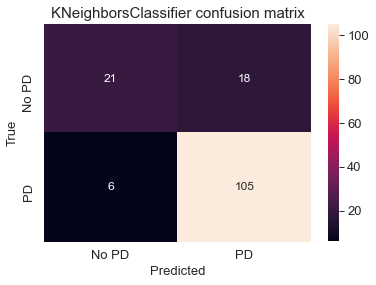

In [145]:
models_results = get_mean_cv_scores_df(KNeighborsClassifier(), X_scaled, y, plot_cm=True)

In [146]:
models_results

Accuracy    Recall  Precision   ROC-AUC
KNeighborsClassifier  0.811085  0.944745   0.826269  0.771027

## LogReg

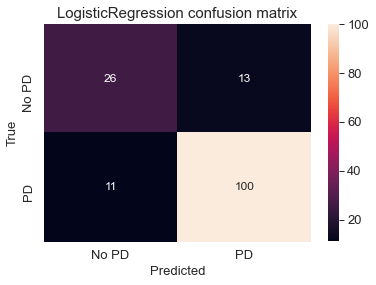

In [147]:
lg_cv = get_mean_cv_scores_df(LogisticRegression(), X_scaled, y, plot_cm=True)

In [148]:
lg_cv

Accuracy    Recall  Precision   ROC-AUC
LogisticRegression  0.809752  0.890676   0.860187  0.832764

In [149]:
models_results = models_results.append(lg_cv)

## DT

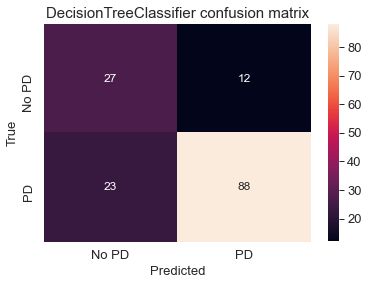

In [150]:
dt_cv = get_mean_cv_scores_df(DecisionTreeClassifier(), X, y, plot_cm=True)

In [151]:
dt_cv

Accuracy    Recall  Precision   ROC-AUC
DecisionTreeClassifier  0.744889  0.823331    0.83236  0.660062

In [152]:
models_results = models_results.append(dt_cv)

## RF

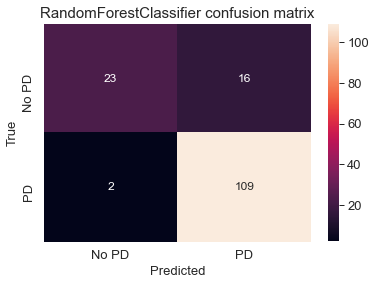

In [153]:
rf_cv = get_mean_cv_scores_df(RandomForestClassifier(), X, y, plot_cm=True)

In [154]:
rf_cv

Accuracy    Recall  Precision   ROC-AUC
RandomForestClassifier   0.82434  0.953548   0.834569  0.837729

In [155]:
models_results = models_results.append(rf_cv)

## CatBoost

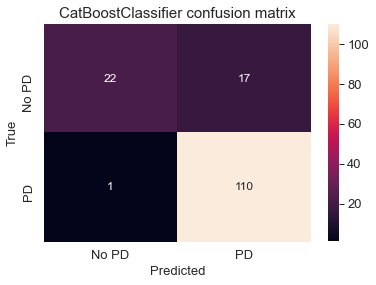

In [156]:
catboost_cv = get_mean_cv_scores_df(CatBoostClassifier(verbose=False), X, y, plot_cm=True)

In [157]:
catboost_cv

Accuracy    Recall  Precision   ROC-AUC
CatBoostClassifier   0.83634  0.970104   0.836977  0.865357

In [158]:
models_results = models_results.append(catboost_cv)

## LightGBM

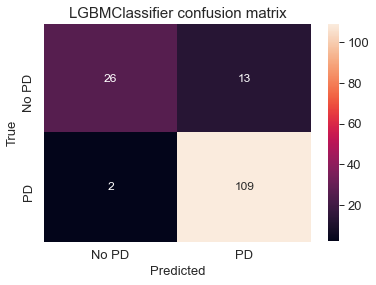

In [159]:
lgbm_cv = get_mean_cv_scores_df(LGBMClassifier(), X, y, plot_cm=True)

In [160]:
lgbm_cv

Accuracy    Recall  Precision   ROC-AUC
LGBMClassifier  0.848209  0.961296   0.854121  0.892603

In [161]:
models_results = models_results.append(lgbm_cv)

## XGBoost

[14:43:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

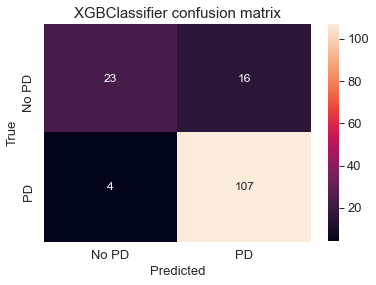

In [162]:
xgb_cv = get_mean_cv_scores_df(XGBClassifier(), X, y, plot_cm=True)

In [163]:
xgb_cv

Accuracy    Recall  Precision   ROC-AUC
XGBClassifier  0.820418  0.945599   0.836007  0.846921

In [164]:
models_results = models_results.append(xgb_cv)

__Models comparison:__

In [165]:
models_results

Accuracy    Recall  Precision   ROC-AUC
KNeighborsClassifier    0.811085  0.944745   0.826269  0.771027
LogisticRegression      0.809752  0.890676   0.860187  0.832764
DecisionTreeClassifier  0.744889  0.823331   0.832360  0.660062
RandomForestClassifier  0.824340  0.953548   0.834569  0.837729
CatBoostClassifier      0.836340  0.970104   0.836977  0.865357
LGBMClassifier          0.848209  0.961296   0.854121  0.892603
XGBClassifier           0.820418  0.945599   0.836007  0.846921

# Upsampling with SMOTENC

Now let's try to cross validate with SMOTENC upsampling

In [171]:
models_results_upsampling = get_mean_cv_scores_df(KNeighborsClassifier(), X_scaled, y, upsampling=True)
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(LogisticRegression(), X_scaled, y, upsampling=True))
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(DecisionTreeClassifier(), X, y, upsampling=True))
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(RandomForestClassifier(), X, y, upsampling=True))
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(CatBoostClassifier(verbose=False), X_scaled, y, upsampling=True))
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(LGBMClassifier(), X, y, upsampling=True))
models_results_upsampling = models_results_upsampling.append(get_mean_cv_scores_df(XGBClassifier(), X, y, upsampling=True))

[14:57:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [172]:
models_results_upsampling

Accuracy    Recall  Precision   ROC-AUC
KNeighborsClassifier    0.631582  0.576217   0.885885  0.757384
LogisticRegression      0.805804  0.875258   0.867320  0.827416
DecisionTreeClassifier  0.748837  0.819063   0.839670  0.677159
RandomForestClassifier  0.807111  0.913790   0.842281  0.826517
CatBoostClassifier      0.825647  0.923927   0.853971  0.869215
LGBMClassifier          0.842771  0.934900   0.865612  0.884912
XGBClassifier           0.837490  0.926184   0.865783  0.861911

Precision of class 1 has increased in every model

# Resampling 

Now let's cross validae on resampled data, so gender proportion in each class are equal

In [173]:
models_results_resampling = get_mean_cv_scores_df(KNeighborsClassifier(), X_scaled, y, resampling=True)
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(LogisticRegression(), X_scaled, y, resampling=True))
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(DecisionTreeClassifier(), X, y, resampling=True))
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(RandomForestClassifier(), X, y, resampling=True))
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(CatBoostClassifier(verbose=False), X_scaled, y, resampling=True))
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(LGBMClassifier(), X, y, resampling=True))
models_results_resampling = models_results_resampling.append(get_mean_cv_scores_df(XGBClassifier(), X, y, resampling=True))

[15:04:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [174]:
models_results_resampling

Accuracy    Recall  Precision   ROC-AUC
KNeighborsClassifier    0.791085  0.914556   0.823563  0.732549
LogisticRegression      0.804654  0.869467   0.868380  0.825786
DecisionTreeClassifier  0.723895  0.801503   0.820460  0.642123
RandomForestClassifier  0.836209  0.959662   0.842627  0.830211
CatBoostClassifier      0.836392  0.964841   0.839529  0.864560
LGBMClassifier          0.844261  0.952326   0.855576  0.879245
XGBClassifier           0.837569  0.939937   0.856183  0.861599

Seems like the scores are a little lower than on raw data, but i would still choose resampled cv further. 

The intuition here is that training on resampled data will be more robust to test sets, that not look like train set (in terms of class/gender proportions).

# Dimensionality Reduction

## PCA

In [226]:
EXPLAINED_VARIANCE = 0.95

pca = PCA(n_components=EXPLAINED_VARIANCE).fit(X_scaled.drop(columns=['id' ]))
pca_data = pca.transform(X_scaled.drop(columns=['id' ]))

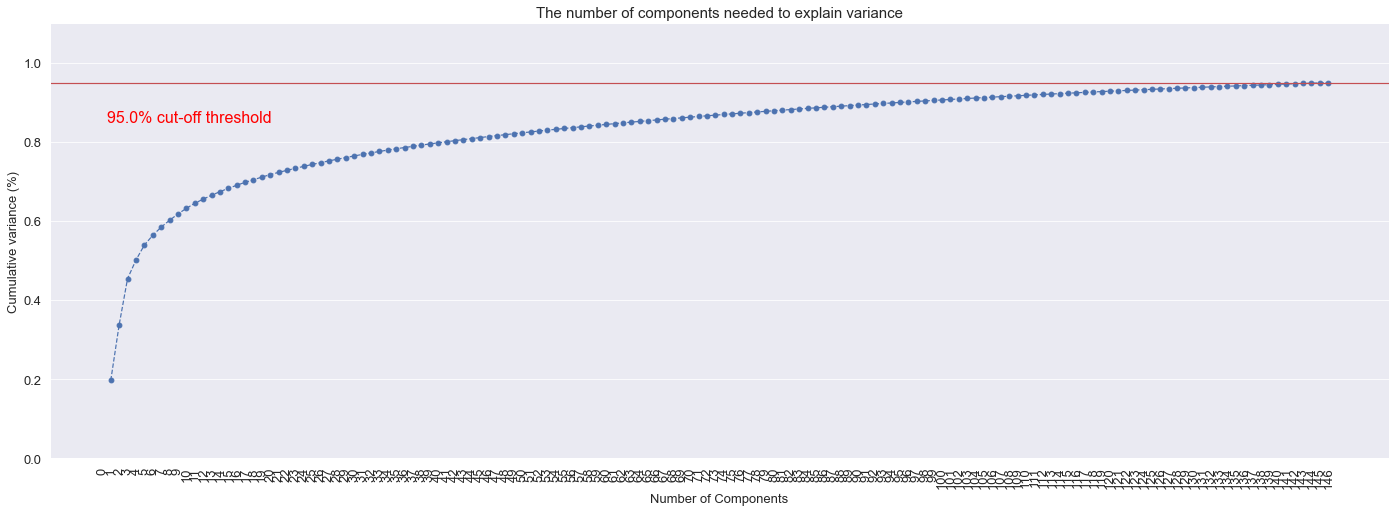

In [227]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(24, 8))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=EXPLAINED_VARIANCE, color='r', linestyle='-')
plt.text(0.5, 0.85, f'{EXPLAINED_VARIANCE*100}% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

In [228]:
X_scaled_pca = pd.DataFrame.from_records(data=pca_data)

In [229]:
X_scaled_pca['id'] = X_scaled['id']

{'Accuracy': [0.7516339869281046,
              0.8266666666666667,
              0.7973856209150327,
              0.7933333333333333,
              0.8333333333333334],
 'Precision': [0.8518518518518519,
               0.907563025210084,
               0.8508771929824561,
               0.8490566037735849,
               0.9056603773584906],
 'ROC-AUC': [0.755510571300045,
             0.7636254140319181,
             0.8232518232518232,
             0.8298412698412698,
             0.8814968814968814],
 'Recall': [0.8070175438596491,
            0.8780487804878049,
            0.8738738738738738,
            0.8571428571428571,
            0.8648648648648649]}


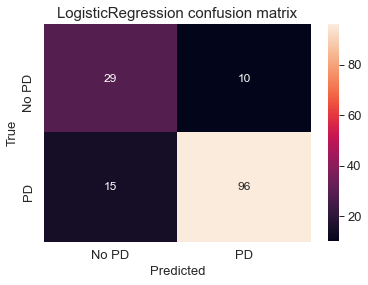

Accuracy   Recall  Precision   ROC-AUC
LogisticRegression  0.800471  0.85619   0.873002  0.810745

In [230]:
get_mean_cv_scores_df(LogisticRegression(), X_scaled_pca, y, print_fold_scores=True, plot_cm=True)

Precision increased, so the model is less overfitted now

In [219]:
def plot_2d(dr_data: np.array, method: str):
    plot_df = pd.DataFrame.from_records(data=dr_data,columns=["x1","x2"])
    plot_df["target"] = y
    sns.set(style="ticks")
    sns.relplot("x1", "x2", data=plot_df, hue="target", palette=['#ff6969', '#69ff8e'])
    plt.title(f'{method}')
    plt.show()

## UMAP

In [293]:
umap_data = UMAP(n_components=30, min_dist=0.3, n_neighbors=40).fit_transform(X_scaled.drop(columns=['id']))

In [294]:
X_scaled_umap = pd.DataFrame.from_records(data=umap_data)

In [295]:
X_scaled_umap['id'] = X_scaled['id']

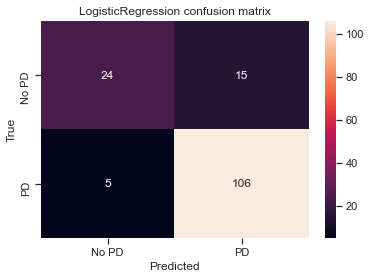

Accuracy    Recall  Precision   ROC-AUC
LogisticRegression  0.816627  0.943919   0.832904  0.767073

In [296]:
get_mean_cv_scores_df(LogisticRegression(), X_scaled_umap, y, plot_cm=True)

Recall increased, Precision descreased

# TODO:
- подробнее покрутить pca и umap, попробовать их на других моделях 
- Barplot explained variance от каждой компоненты в pca 
- визуализация umap и pca на 3d
- выбрать итоговый набор данных и модель
- tuning модели
- stacking models (?)